# Advanced usage

This notebook replicates what was done in the *simple_usage* notebooks, but this time with the advanced API. The advanced API is required if we want to use non-standard affinity methods that better preserve global structure.

If you are comfortable with the advanced API, please refer to the *preserving_global_structure* notebook for a guide how obtain better embeddings and preserve more global structure.

In [1]:
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization

from examples import utils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Load data

In [2]:
import gzip
import pickle

with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


## Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [5]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

30021 training samples
14787 test samples


## Create a t-SNE embedding

Like in the *simple_usage* notebook, we will run the standard t-SNE optimization.

This example shows the standard t-SNE optimization. Much can be done in order to better preserve global structure and improve embedding quality. Please refer to the *preserving_global_structure* notebook for some examples.

**1. Compute the affinities between data points**

In [6]:
%%time
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 3.78 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.43 seconds
CPU times: user 19.3 s, sys: 794 ms, total: 20.1 s
Wall time: 4.22 s


**2. Generate initial coordinates for our embedding**

In [7]:
%time init_train = initialization.pca(x_train, random_state=42)

CPU times: user 448 ms, sys: 88.3 ms, total: 536 ms
Wall time: 86.9 ms


**3. Construct the `TSNEEmbedding` object**

In [8]:
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)

**4. Optimize embedding**

1. Early exaggeration phase

In [9]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

===> Running optimization with exaggeration=12.00, lr=2501.75 for 250 iterations...
Iteration   50, KL divergence 5.8046, 50 iterations in 1.8747 sec
Iteration  100, KL divergence 5.2268, 50 iterations in 2.0279 sec
Iteration  150, KL divergence 5.1357, 50 iterations in 1.9912 sec
Iteration  200, KL divergence 5.0977, 50 iterations in 1.9626 sec
Iteration  250, KL divergence 5.0772, 50 iterations in 1.9759 sec
   --> Time elapsed: 9.83 seconds
CPU times: user 1min 11s, sys: 2.04 s, total: 1min 13s
Wall time: 9.89 s


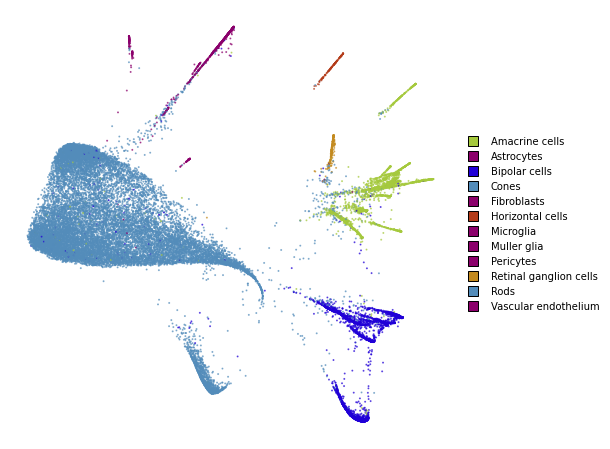

In [10]:
utils.plot(embedding_train_1, y_train, colors=utils.MACOSKO_COLORS)

2. Regular optimization

In [11]:
%time embedding_train_2 = embedding_train_1.optimize(n_iter=500, momentum=0.8)

===> Running optimization with exaggeration=1.00, lr=2501.75 for 500 iterations...
Iteration   50, KL divergence 3.5741, 50 iterations in 1.9240 sec
Iteration  100, KL divergence 3.1653, 50 iterations in 1.9942 sec
Iteration  150, KL divergence 2.9612, 50 iterations in 2.3730 sec
Iteration  200, KL divergence 2.8342, 50 iterations in 3.4895 sec
Iteration  250, KL divergence 2.7496, 50 iterations in 4.7873 sec
Iteration  300, KL divergence 2.6901, 50 iterations in 5.2739 sec
Iteration  350, KL divergence 2.6471, 50 iterations in 6.9968 sec
Iteration  400, KL divergence 2.6138, 50 iterations in 7.8137 sec
Iteration  450, KL divergence 2.5893, 50 iterations in 9.5210 sec
Iteration  500, KL divergence 2.5699, 50 iterations in 10.6958 sec
   --> Time elapsed: 54.87 seconds
CPU times: user 6min 2s, sys: 20.3 s, total: 6min 23s
Wall time: 55.1 s


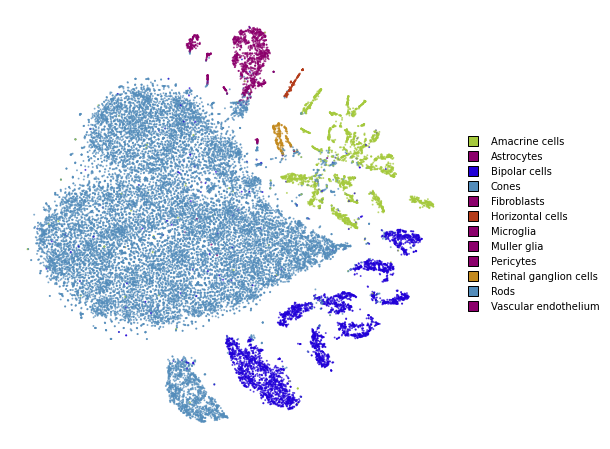

In [12]:
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS)

## Transform

In [13]:
%%time
embedding_test = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 1.11 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
CPU times: user 3 s, sys: 192 ms, total: 3.19 s
Wall time: 1.15 s


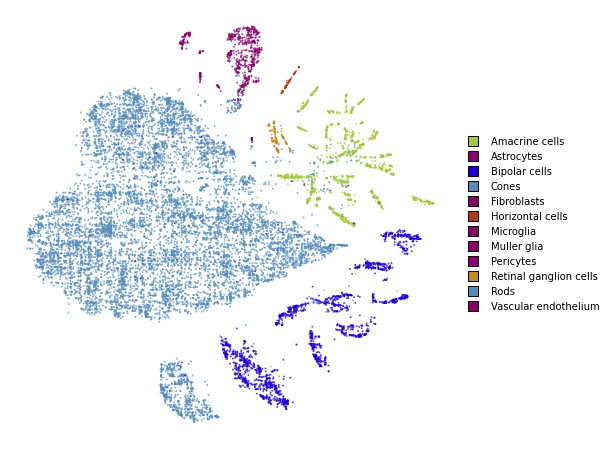

In [14]:
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS)

In [15]:
%time embedding_test_1 = embedding_test.optimize(n_iter=250, learning_rate=0.1, momentum=0.8)

===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 226760.6820, 50 iterations in 0.3498 sec
Iteration  100, KL divergence 221529.7066, 50 iterations in 0.4099 sec
Iteration  150, KL divergence 215464.6854, 50 iterations in 0.4285 sec
Iteration  200, KL divergence 211201.7247, 50 iterations in 0.4060 sec
Iteration  250, KL divergence 209022.1241, 50 iterations in 0.4211 sec
   --> Time elapsed: 2.02 seconds
CPU times: user 10.7 s, sys: 889 ms, total: 11.6 s
Wall time: 2.74 s


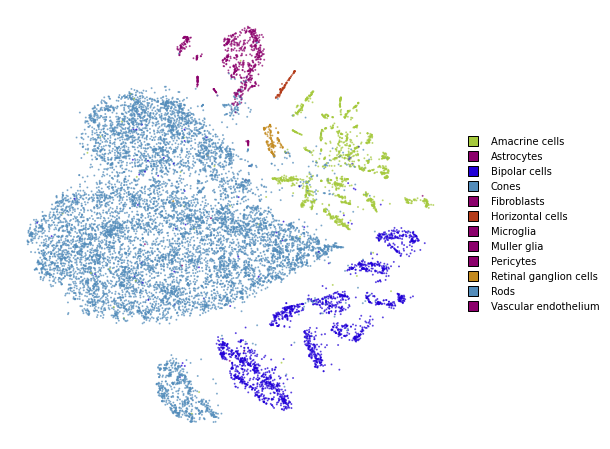

In [16]:
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

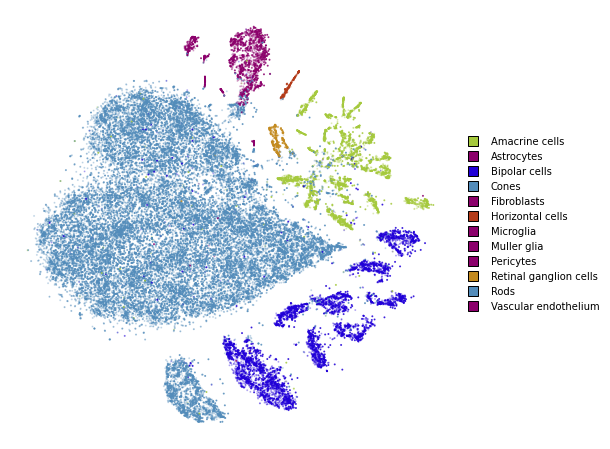

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS, alpha=0.25, ax=ax)
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS, alpha=0.75, ax=ax)